In [1]:
import os
import numpy as np
from pathlib import Path
import spikeinterface.full as si

Matplotlib created a temporary cache directory at /tmp/matplotlib-xipq1_12 because the default path (/home/jupyter-ikharitonov/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Create a sorting object from Allen SDK data

In [2]:
sampling_frequency = 29999.954846
session_id = 715093703
probe_id = 810755797

path_to_save_spike_data = Path.home()/'RANCZLAB-NAS/iakov/data'

In [3]:
if os.environ['CONDA_DEFAULT_ENV'] == 'jh_allendata':
    from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

    cache = EcephysProjectCache.from_warehouse(manifest = Path.home() / 'RANCZLAB-NAS' / 'allensdk_ecephys_data' / 'manifest.json')
    session = cache.get_session_data(session_id)
    recorded_unit_ids = session.units[session.units.probe_id==probe_id].index.to_list()
    spike_times_dict = {uid: list(session.spike_times[uid]) for uid in recorded_unit_ids}
    
    
    
    # Creates 1D spike times and spike labels lists from the dictionary
    # And sorts them in ascending order

    spike_times = []
    spike_labels = []

    for k, v in spike_times_dict.items():
        spike_times += v
        spike_labels += [k for i in range(len(v))]

    sorted_indices = np.argsort(np.array(spike_times))

    # Use the sorted indices to sort both arrays
    spike_times = np.array(spike_times)[sorted_indices]
    spike_labels = np.int_(np.array(spike_labels)[sorted_indices])

    np.save(path_to_save_spike_data/f'spike_times_labels_sid_{session_id}_pid_{probe_id}.npy', [spike_times, spike_labels])

else:
    spike_times, spike_labels = np.load(path_to_save_spike_data/f'spike_times_labels_sid_{session_id}_pid_{probe_id}.npy')
    spike_labels = np.int_(spike_labels)
    allen_sorting = si.NumpySorting.from_times_labels(spike_times, spike_labels, sampling_frequency)
    print(allen_sorting)

NumpySorting: 78 units - 1 segments - 30.0kHz


### Load local sorting and compare the two

In [4]:
# path1 = Path.home() / 'RANCZLAB-NAS/iakov/allen_sorting_ks2_10_jan_v_corr'
path2 = Path.home() / 'RANCZLAB-NAS/iakov/allen_sorting_ks3_10_jan'

In [5]:
# sorting1 = si.read_sorter_folder(path1)
local_sorting = si.read_sorter_folder(path2)

/opt/tljh/user/envs/jh_si_env/lib/python3.10/site-packages/spikeinterface/core/base.py:1011: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.100.0.dev0 is recommended
  warnings.warn(


           0    1    2    3    4    5    6    8    9    10   ...  431  432  \
950910352    1    3    0    0   35   41    7    0    0    0  ...   21    0   
950910364    1    4    0    0   36   41    7    0    0    0  ...   21    0   
950910371    1    4    0    0   36   41    7    0    0    0  ...   21    0   
950910392    1    4    0    0   36   41    7    0    0    0  ...   21    0   
950910435    1    4    0    0   36   41    7    0    0    0  ...   21    0   
...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
950912940    1    4    0    0   36   41    7    0    0    0  ...   21    0   
950912952    1    4    0    0   36   41    7    0    0    0  ...   21    0   
950913000    1    4    0    0   35   41    7    0    0    0  ...   21    0   
950913031    0    3    0    0   30   31    6    0    0    0  ...   18    0   
950913096    1    4    0    0   36   41    7    0    0    0  ...   21    0   

           433  434  435  436  437  439  440  441  
950910352  

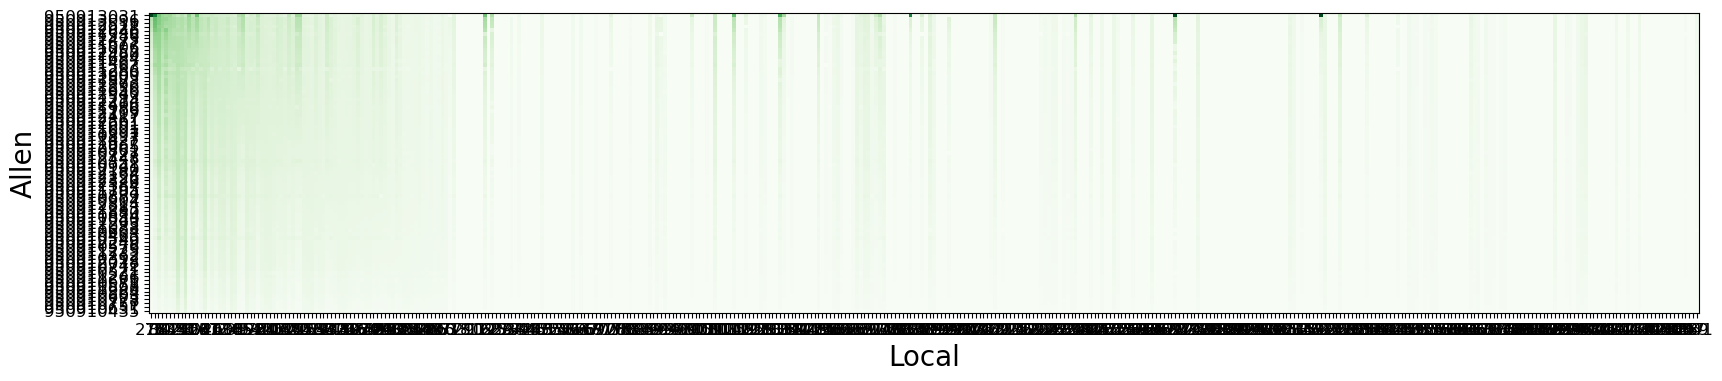

In [6]:
# Run the comparison
# Let’s see how to inspect and access this matching.
cmp_Al_Loc = si.compare_two_sorters(
    sorting1=allen_sorting,
    sorting2=local_sorting,
    sorting1_name='Allen',
    sorting2_name='Local',
)

# We can check the agreement matrix to inspect the matching.
si.plot_agreement_matrix(cmp_Al_Loc, figsize=(20,15))

# Some useful internal dataframes help to check the match and count
#  like **match_event_count** or **agreement_scores**
print(cmp_Al_Loc.match_event_count)
print(cmp_Al_Loc.agreement_scores)

# In order to check which units were matched, the :code:`get_matching`
# method can be used. If units are not matched they are listed as -1.
allen_to_local, local_to_allen = cmp_Al_Loc.get_matching()
print('matching Allen to Local')
print(allen_to_local)
print('matching Local to Allen')
print(local_to_allen)